# Mesh Deformation using differentiable rendering and 3D Loss:

This project implements an ML algorithm to deform a source mesh to fit a target mesh. The renderer also estimates the texture of the mesh


Mesh vertices are modified to match the silhouette of the *** rendered from various perspectives. It will also solve for the texture simultaneously. Mesh deformation is optimised for both silhouette and texture prediction.

The following loss functions are utilised to quantify error and optimise the model:


## Imports and helper functions

In [ ]:
#Building wheels for packages pytorch3d and iopath takes around 30 minutes
import os
import sys
import torch
from google.colab import drive

need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [ ]:
import warnings
from math import log

import numpy as np
import torch
from tqdm.notebook import trange
import matplotlib.pyplot as plt

from pytorch3d.io import load_objs_as_meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.loss import (
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    TexturesVertex
)

from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

%matplotlib inline

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Helper functions:

In [ ]:
# this helper function is sourced from the course: 3d Machine Learning with PyTorch3D
# https://www.educative.io/courses/3d-machine-learning-with-pytorch3d/texture-estimation
def image_grid(
    images,
    rows=None,
    cols=None,
    fill: bool = True,
    show_axes: bool = False,
    rgb: bool = True,
):
    """
    A util function for plotting a grid of images.

    Args:
        images: (N, H, W, 4) array of RGBA images
        rows: number of rows in the grid
        cols: number of columns in the grid
        fill: boolean indicating if the space between images should be filled
        show_axes: boolean indicating if the axes of the plots should be visible
        rgb: boolean, If True, only RGB channels are plotted.
            If False, only the alpha channel is plotted.

    Returns:
        None

    Copyright (c) Meta Platforms, Inc. and affiliates.
    All rights reserved.

    This source code is licensed under the BSD-style license found in the
    LICENSE file in the root directory of this source tree.
    """
    if (rows is None) != (cols is None):
        raise ValueError("Specify either both rows and cols or neither.")

    if rows is None:
        rows = len(images)
        cols = 1

    gridspec_kw = {"wspace": 0.0, "hspace": 0.0} if fill else {}
    fig, axarr = plt.subplots(rows, cols, gridspec_kw=gridspec_kw, figsize=(15, 9))
    bleed = 0
    fig.subplots_adjust(left=bleed, bottom=bleed, right=(1 - bleed), top=(1 - bleed))

    for ax, im in zip(axarr.ravel(), images):
        if rgb:
            # only render RGB channels
            ax.imshow(im[..., :3])
        else:
            # only render Alpha channel
            ax.imshow(im[..., 3])
        if not show_axes:
            ax.set_axis_off()

In [ ]:
# this helper function is sourced from the course: 3d Machine Learning with PyTorch3D
# https://www.educative.io/courses/3d-machine-learning-with-pytorch3d/texture-estimation

#function to compute all of the loss terms together
def update_mesh_shape_prior_losses(mesh, loss):
    """
    Compute shape prior losses and apply to loss dict
    """
    loss['edge'] = mesh_edge_loss(mesh)
    loss['normal'] = mesh_normal_consistency(mesh)
    loss['laplacian'] = mesh_laplacian_smoothing(mesh, method='uniform') #try other 2 variants and see how it affects performance

In [ ]:
# this helper function is sourced from the course: 3d Machine Learning with PyTorch3D
# https://www.educative.io/courses/3d-machine-learning-with-pytorch3d/texture-estimation

# functions to display our training progress and results.
def display_prediction(predicted_mesh,
                       renderer,
                       target_image,
                       title='',
                       silhouette=False):
    """
    Display rendered image of prediction
    """
    channel = 3 if silhouette else range(3)
    with torch.no_grad():
        predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., channel].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.axis(False)

In [ ]:
# this helper function is sourced from the course: 3d Machine Learning with PyTorch3D
# https://www.educative.io/courses/3d-machine-learning-with-pytorch3d/texture-estimation
def plot_losses(losses):
    """
    Plot losses across iterations
    """
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for key, val in losses.items():
        ax.plot(val['values'], label=f'{key} loss')
    ax.legend(fontsize='16')
    ax.set_xlabel('Iteration', fontsize='16')
    ax.set_ylabel('Loss', fontsize='16')
    ax.set_title('Loss Plot', fontsize='16')

## Load meshes

In [ ]:
# 3D model sourced from BlenderKit
# credit to artist: Marinko Tambur
# https://www.blenderkit.com/asset-gallery-detail/22b280a9-e03a-423d-a114-8a41d9869033/
src_path = '/content/drive/MyDrive/3D Assets/Downsized Ornithopter/ornithopter.obj'
target_mesh = load_objs_as_meshes([src_path], device=device)

In [ ]:
target_mesh.textures

In [ ]:
# credit to artist: DDD
# https://www.blenderkit.com/get-blenderkit/362e45ed-9ec5-4416-9cd6-72f418333569/
src_path = '/content/drive/MyDrive/3D Assets/Dragonfly/dragonfly.obj'
src_mesh = load_objs_as_meshes([src_path], device=device)

In [ ]:
src_mesh.textures

## Visualize meshes

In [ ]:
# plt.figure(figsize=(7,7))
# texturesuv_image_matplotlib(mesh.textures, subsample=None)

## Heterogeneous Batching:
Implemented using PyTorch 'packed batching' --
pytorch3d.ops.graph_conv expects a packed representation

In [ ]:
verts = target_mesh.verts_packed() #pack mesh vertices together into a single tensor of shape (sum(V_n), 3).

# Shift and scale the vertices of the mesh such that it has a mean of (0, 0, 0) and range [-1, 1]. This improves the model training convergence.
# the `offset_verts_` and `scale_verts_` functions which modify the vertices of the mesh in-place.
center = verts.mean(axis=0)
_ = target_mesh.offset_verts_(-center)

In [ ]:
# reinitialise verts so that the scale factor is calculated based on
# the original packed vertices, not the already centered vertices
verts = target_mesh.verts_packed()
scale = (verts - center).abs().max()
_ = target_mesh.scale_verts_(1. / scale.item())

In [ ]:
print(f'Min: {target_mesh.verts_packed().min(axis=0)[0]}')
print(f'Max: {target_mesh.verts_packed().max(axis=0)[0]}')

Min: tensor([-0.7875, -0.1265, -1.1578], device='cuda:0')
Max: tensor([0.7868, 0.4458, 0.4092], device='cuda:0')


## Create a dataset

Render the target mesh from a variety of angles and elevations to create a training dataset. The dataset currently consists of textured renders and silhouette renders of the object. The silhouette training images will act as a ground truth (GT) for mesh shape and the textured training images will act as the GT for texture estimation.

### Setup camera poses

In [ ]:
# calculate bounding box of the mesh to dynamically adjust camera distance so that the object is always in frame
verts = target_mesh.verts_list()[0]
min_coords = verts.min(dim=0).values
max_coords = verts.max(dim=0).values
mesh_bbox = (max_coords - min_coords).max()

# calculate camera distance to accomodate entire mesh
fov_rad = torch.deg2rad(torch.tensor(100.0))  # Field of view in radians
cam_dist = mesh_bbox / (2 * torch.tan(fov_rad / 2)) * 1.2 # Add a small buffer

# setup settings
num_views = 24    # the number of images to generate
# cam_dist = 0.75  # the distance of the camera from the object centroid

# create the view angles for our cameras in the form (elevation, azimuth)
angles = torch.stack([
    torch.linspace(0, 360, num_views),    # elevation
    torch.linspace(-180, 180, num_views)  # azimuth
], axis=-1)

# create a batch of camera views using the view angles (all at radius dist from center)
R, T = look_at_view_transform(dist=cam_dist, elev=angles[:, 0], azim=angles[:, 1])
# cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=100)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=fov_rad)

# extend mesh to the number of views
target_meshes = target_mesh.extend(num_views)

In [ ]:
def calculate_cam_dist(object_bbox: torch.tensor,
                       fov: torch.tensor,
                       elevation: torch.tensor) -> torch.tensor:
    BUFFER = 1.2
    projected_extent = object_bbox * torch.abs(torch.sin(elevation)) + object_bbox * torch.abs(torch.cos(elevation)) * 0.5 # Heuristic
    distance = projected_extent / (2 * torch.tan(fov / 2) + 1e-6) * BUFFER
    return torch.clamp(distance, min=object_bbox * 0.5) # set minimum camera dist

In [ ]:
# camera settings
num_views = 24
camera_fov = 100
# convert fov to radians as torch.tan and torch.sin expect arguments to be in radians, not degrees.
fov_rad = torch.deg2rad(torch.tensor(camera_fov, device=device))

# 1. Get the bounding box of the mesh
verts = target_mesh.verts_list()[0]
min_coords = verts.min(dim=0).values
max_coords = verts.max(dim=0).values
object_extent = (max_coords - min_coords).max()
object_extent.to(device)
object_centroid = (max_coords + min_coords) / 2
#reshape object_centroid to be compatible for broadcasting with the angles tensor
# look_at_view_transform() requires input tensors to be compatible shapes
object_centroid = object_centroid.unsqueeze(0).repeat(num_views, 1)
object_centroid.to(device)

# create the view angles for our cameras in the form (elevation, azimuth)
angles = torch.stack(
    [
        torch.linspace(0, 360, num_views, device=device),  # elevation
        torch.linspace(-180, 180, num_views, device=device),  # azimuth
    ],
    axis=-1,
)
elevation_rad = torch.deg2rad(angles[:, 0])

# use torch.vmap to calculate the camera dist for each view (render) based on elevation
# vmap is more efficient than a loop as it can leverage parallel processing
mapping = torch.vmap(func=calculate_cam_dist,
                               in_dims=(None, None, 0)) #iterate over the first dim of the last calculate_cam_dist() parameter

required_cam_dist = mapping(object_extent, fov_rad, elevation_rad)

# create a batch of camera views using the view angles (all at radius dist from center)
R, T = look_at_view_transform(dist=required_cam_dist, elev=angles[:, 0], azim=angles[:, 1], at=object_centroid)
cameras = FoVPerspectiveCameras(device=target_mesh.device, R=R, T=T, fov=camera_fov)

# extend mesh to the number of views
target_meshes = target_mesh.extend(num_views)

### Setup texture renderer

In [ ]:
image_size = 400 #a smaller image size results in pixelation

# create a point light in front of the object to illuminate the scene
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# create rasterization settings
vis_raster_settings = RasterizationSettings(
    image_size=image_size,
    blur_radius=0.0,
    faces_per_pixel= 1,
)

test_idx = 1
# create a soft phong shader to display the mesh with texture
vis_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        raster_settings=vis_raster_settings,
        cameras=cameras[test_idx]
    ),
    shader=SoftPhongShader(
        device=device,
        lights=lights,
        cameras=cameras[test_idx]
    )
)

### Setup silhouette render

In [ ]:
# Silhouette renderer
sil_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras[test_idx],
        raster_settings=vis_raster_settings
    ),
    shader=SoftSilhouetteShader()
)

### Create renders

In [ ]:
rendered_imgs = vis_renderer(target_meshes, cameras=cameras)
target_rgb = [img[..., :3] for img in rendered_imgs]

In [ ]:
rendered_sils = sil_renderer(target_meshes, cameras=cameras)
target_sil = [img[..., 3] for img in rendered_sils]

In [ ]:
# mesh.textures.maps_padded() #(N, H, W, C), where N is the number of meshes, H is the height, W is the width, and C is the number of channels of the single texture map associated with the UV mapping.

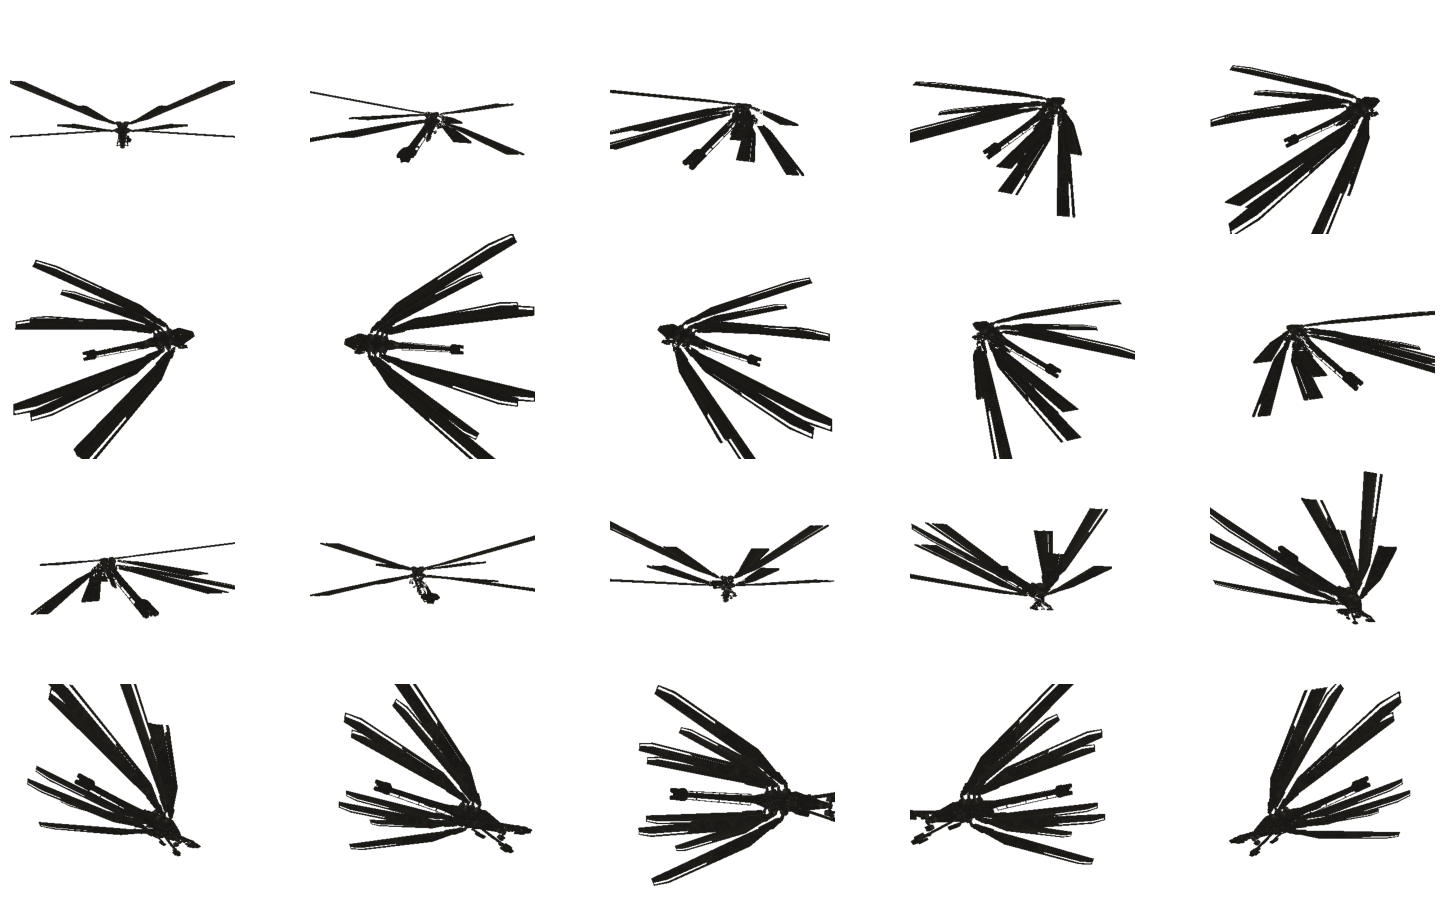

In [ ]:
# display view dataset
n_cols = 5
image_grid(rendered_imgs.cpu().numpy(), rows=num_views // n_cols,
           cols=n_cols, rgb=True)
plt.show()

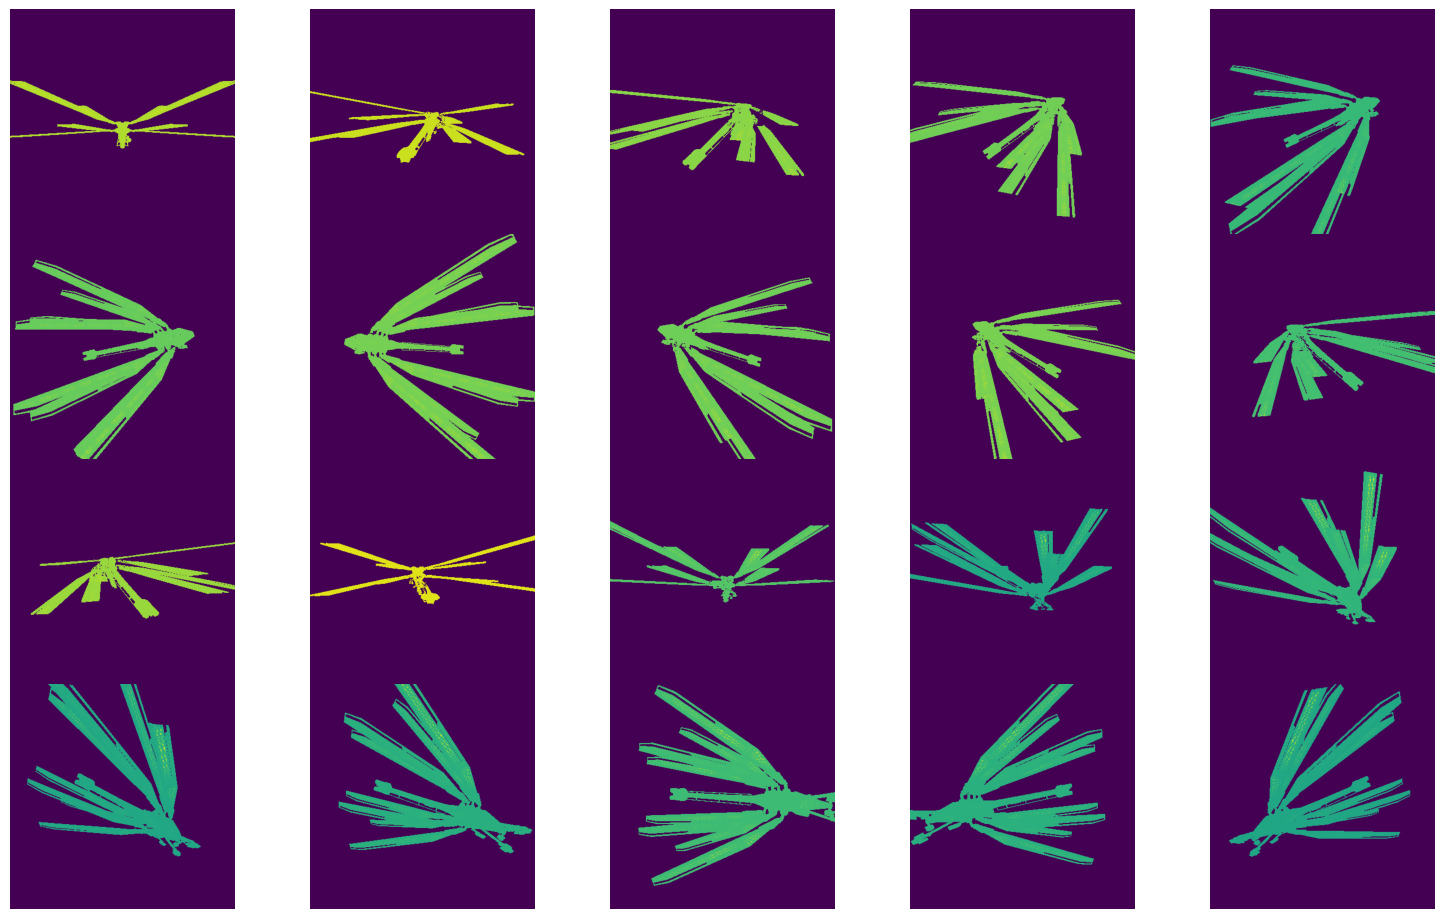

In [ ]:
# display view dataset
n_cols = 5
image_grid(rendered_sils.cpu().numpy(), rows=num_views // n_cols,
           cols=n_cols, rgb=False)
plt.show()

In [ ]:
# src_mesh, deform_verts, sphere_verts_rgb = create_template_mesh()